In [1]:
import os

os.environ["HUGGINGFACE_HUB_CACHE"] = "/data/sshadmin/bocheng/.cache/huggingface/hub/"
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDIMScheduler, DDPMPipeline
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm

device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

diffusion_pytorch_model.safetensors not found
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "google/ddpm-celebahq-256",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

100%|██████████| 1000/1000 [00:24<00:00, 40.71it/s]


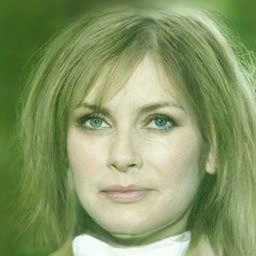

In [3]:
images = image_pipe().images
images[0]

In [4]:
from diffusers.schedulers import DDIMScheduler
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)
scheduler.timesteps

tensor([975, 950, 925, 900, 875, 850, 825, 800, 775, 750, 725, 700, 675, 650,
        625, 600, 575, 550, 525, 500, 475, 450, 425, 400, 375, 350, 325, 300,
        275, 250, 225, 200, 175, 150, 125, 100,  75,  50,  25,   0])

0it [00:00, ?it/s]

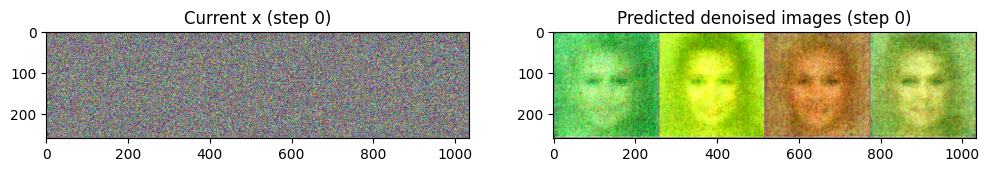

10it [00:00, 13.93it/s]

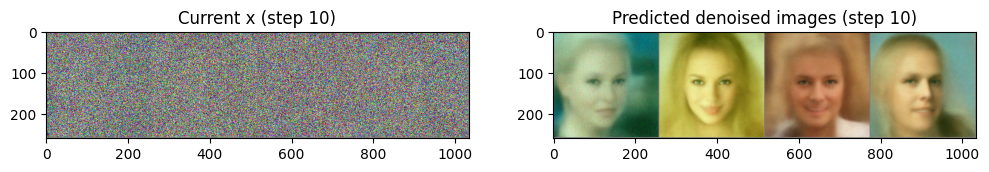

20it [00:01, 15.61it/s]

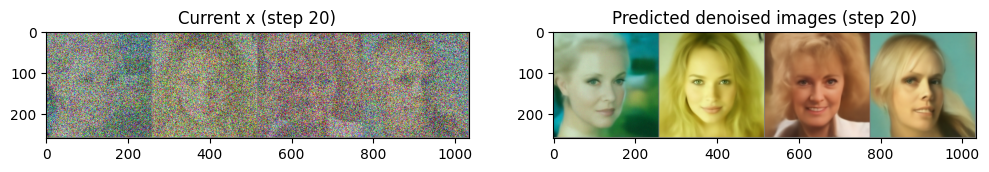

30it [00:02, 16.05it/s]

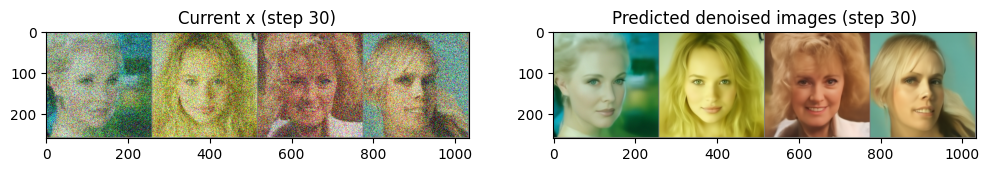

38it [00:03, 15.16it/s]

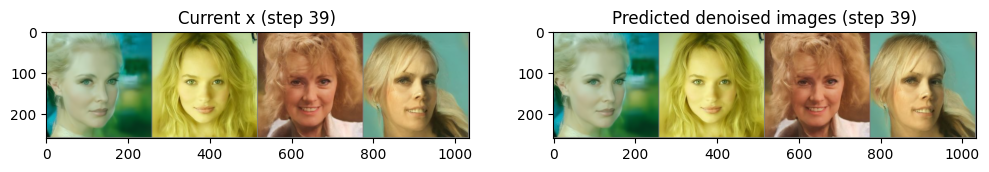

40it [00:03, 11.56it/s]


In [5]:
from tqdm import tqdm

x = torch.randn(4, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t) #给带噪图像加上时间步信息
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"] #预测噪声
    scheduler_output = scheduler.step(noise_pred, t, x) #更新样本
    x = scheduler_output.prev_sample #更新后的图像
    # 时不时看一下输入图像和预测的“去噪”图像
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = scheduler_output.pred_original_sample
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)

        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()

100%|██████████| 40/40 [00:01<00:00, 30.91it/s]


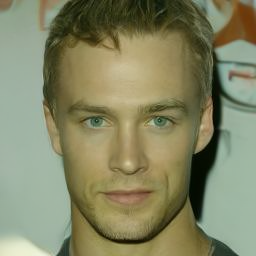

In [6]:
image_pipe.scheduler = scheduler
images = image_pipe(num_inference_steps=40).images
images[0]

### 加载蝴蝶数据集

In [7]:
dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(
    dataset_name,
    split="train",
    cache_dir="/data/sshadmin/bocheng/data/huggingface/data",
)
image_size=256
batch_size=4
preprocess=transforms.Compose(
    [
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5])
    ]
)

def transform(examples):
    images=[preprocess(image.convert("RGB")) for image in examples['image']]
    return {"images":images}
dataset.set_transform(transform)

train_dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True)

/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Previewing batch:


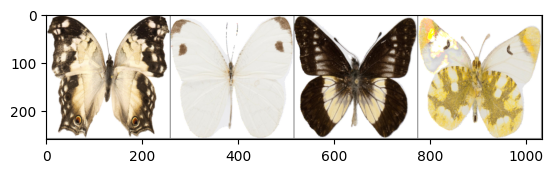

In [8]:
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

### 微调人脸生成扩散模型

  0%|          | 0/250 [00:00<?, ?it/s]/data/sshadmin/bocheng/soft/installed/miniconda3/lib/python3.11/site-packages/diffusers/configuration_utils.py:135: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDIMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDIMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 250/250 [00:48<00:00,  5.19it/s]


Epoch 0 average loss: 0.013952550120040541


100%|██████████| 250/250 [00:47<00:00,  5.29it/s]

Epoch 1 average loss: 0.013292819425347262


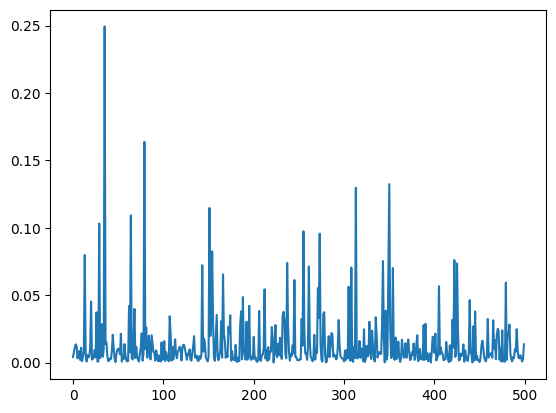

In [9]:
num_epochs=2
lr=1e-5
gradient_accumulation_steps=2

optimizer=torch.optim.AdamW(image_pipe.unet.parameters(),lr=lr)
losses=[]
for epoch in range(num_epochs):
    for step,batch in tqdm(enumerate(train_dataloader),total=len(train_dataloader)):
        clean_images=batch["images"].to(device)
        noise=torch.randn(clean_images.shape).to(clean_images.device)
        bs=clean_images.shape[0]
        timesteps=torch.randint(0,image_pipe.scheduler.num_train_timesteps,(bs,),device=clean_images.device).long()
        noisy_images=image_pipe.scheduler.add_noise(clean_images,noise,timesteps)
        noise_pred=image_pipe.unet(noisy_images,timesteps,return_dict=False)[0]
        loss=F.mse_loss(noise_pred,noise)
        losses.append(loss.item())
        loss.backward()
        if(step+1)%gradient_accumulation_steps==0:
            optimizer.step()
            optimizer.zero_grad()
    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}")
  
plt.plot(losses)      

### 使用微调好的模型生成图像

40it [00:03, 10.16it/s]


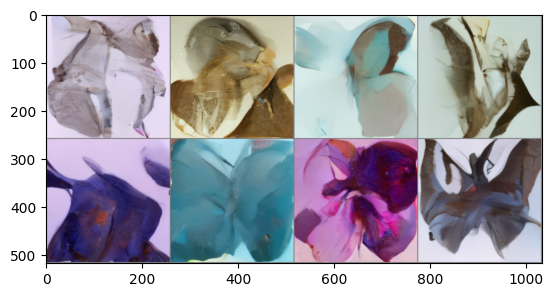

: 

In [10]:
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)